 <font color = 'red' > <font size = '5' >Loading Data and Data Cleaning(missing values)

In [771]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats

from sklearn import preprocessing 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import Imputer

#import xgboost as xgb
from functools import reduce
from imblearn.over_sampling import SMOTE
import itertools
import copy
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

# Functions 
### Clean, concatenate, rename, value counts(frequency of values), get dummies, deal with (don't know)/(refuse)

In [772]:
# function:  clean_epsilon(cell)
# purpose:   in the orginal files, zeros are represented by a small value (10^-79), convert them to actual zeros
# input:     a dataframe that with (10^-79) as zeroes 
# output:    a dataframe with actual zeroes 

def clean_epsilon(cell):
    if cell - 0.0 < 0.0001:
        return 0
    return cell


In [773]:
# function:  concat_rename_dfs(file_cols,renamed_cols,csv_name)
# purpose:   concatenate chosen dfs from multi years, and rename the chosen cols 
# input:     file_cols: a list of tuples contains multi year info [(XPTfile,names of cols in XPT),(),(),...] 
#            renamed_cols: a list of strings - assign new names to cols ['','',...]
#            csv_name: a string that is the name of the output csv file "___.csv"
# output:    a concatenated dataframe with index being SEQN and cols names that make sense 

def concat_rename_dfs(file_cols,renamed_cols,csv_name):
    dfs = pd.DataFrame(columns = renamed_cols)
    for tp in file_cols:
        file = tp[0]
        cols = tp[1]
        df = file[cols]        
        df.columns = renamed_cols
        dfs = pd.concat([dfs, df])                      
    dfs = dfs.applymap(clean_epsilon)                
    dfs.set_index("SEQN", inplace=True)             # set SEQN to index of the df 
    dfs = dfs[~dfs.index.duplicated(keep='first')]  # if has duplicated SEQN's, keep the first one 
    # dfs.to_csv(csv_name,index=False,sep=',')      # uncomment this line if needs to get csv files 
    return dfs

In [774]:
# function:  get_value_count(dfs,renamed_cols,cols_type)
# purpose:   let us know the value counts in each col within the dataframe 
# input:     dfs 
#            renamed_cols: a list of strings, same as the list used in function (concat_rename_dfs)
#            cols_type: a list of strings indicating the datatype of the cols in the renamed_cols
#                       'c': categorical, 'n':numerical
# output:    value counts of each col within the dataframe

def get_value_count(dfs,renamed_cols,cols_type):
    print()
    # the first element is SEQN
    renamed_cols = renamed_cols[1:]
    cols_type = cols_type[1:]
    for i in range(len(renamed_cols)):
        print()
        col_name = renamed_cols[i]
        col_type = cols_type[i]
        if col_type == 'c':      
            print('NaN   ',dfs[col_name].isna().sum())
            print(dfs[col_name].value_counts())
        else: # col_type == 'n'
            print(dfs[col_name].describe())

In [775]:
# function:  convert_nominal_to_dummies(dfs,col_name,dummies_name)
# purpose:   convert the target column from a ***nominal variable*** (ex: gender -> male/female)
#            to dummies variables (male: 1/0, female: 1/0)
# input:     dfs: dataframe containing the nominal column
#            col_name: the name of the nominal col: 'gender' 
#            dummies_name: a list, with names of the dummies:
#                          ex: in gender, 1 = male, 2 = female, dummies_name = ['male','female']
#                          need to consider 7/9 in dummies_name, either drop 77/99 before calling this function
#                          or will have two additional dummy columns for 77/99
# output:    dfs with nominal col converted to dummies

def convert_nominal_to_dummies(dfs,col_name,dummies_name):
    dummy = pd.get_dummies(dfs[col_name])
    dummy.columns = dummies_name
    dfs = pd.merge(dfs, dummy, on = 'SEQN', left_index = True, sort = False)
    dfs = dfs.drop([col_name],axis=1)
    return dfs

In [776]:
def get_79_ratio(dfs,col_name,cstr):
    total_count = dfs.shape[0]
    dk = cstr[0] # don't know
    refuse = cstr[1]  # refuse to answer
    dk = (dfs[col_name] == dk).sum()
    refuse = (dfs[col_name] == refuse).sum()
    dk = int(dk)
    refuse = int(refuse)
    r1 = dk/total_count
    r2 = refuse/total_count
    print()
    print('The ratio of [dont know] is',"%.3f" % r1)
    print('The ratio of [refuse] is',"%.3f" % r2)
    print('Now call: process_79(dfs,col_name,cstr,method)')
    
# THIS IS NOT USED ANYWHERE YET
# function:  drop_79(dfs,col_name,cstr)
# purpose:   drop the entry if it contains 7/9, 77/99, 777/999... 
# input:     dfs: a dataframe with target col containing cstr
#            col_name: a string, target col name
#            cstr: a list with first item = code for don't know, second item = refuse to answer
#            method: a string -> 'drop','NaN',
#                    if the number of 7/9 is small, then 'drop'
#                    if the number of 7/9 is large, can treat as NaN and predict late, 'NaN'
# output:    a dataframe without cstr

def process_79(dfs,col_name,cstr,method):
    dk = cstr[0] # don't know
    refuse = cstr[1]  # refuse to answer
    if method == 'drop':
        dfs = dfs[dfs[col_name] != dk]
        dfs = dfs[dfs[col_name] != refuse]
    elif method == 'NaN':
        dfs[col_name][dfs[col_name] == dk] = np.nan
        dfs[col_name][dfs[col_name] == refuse] = np.nan
    else:
        print('The method you choose is not included yet, add new method now!')
    return dfs

## Dealing with missing values
1. Get missing values information
    1. Get the ratio of missing values
    2. Visualize abundances of missing values between different features 
    
    
2. Fill or predict missing values 
    1. Fill NaN will mean/mode
    2. Predict NaN with machine learning algorithms
    

### 1. Get missing values information 

??? need to determine the ratio for direct fill, predict using ML and drop

In [777]:
# function:  get_NaN_ratio_for_one_col(dfs,col_name)
# purpose:   get the ratio of (missing values)/(total entries) for ***one column***  
# input:     dfs: dataframe that contains the column you want to check for NaN ratio
#            col_name: the name of the column you want to check           
# output:    NaN ratio of the column, and instructions on what to do next 

def get_NaN_ratio_for_one_col(dfs,col_name):
    print()
    total_count = dfs.shape[0]              # total entries
    col_valid_count = dfs[col_name].count() # valid entries for chosen col
    col_null_count = total_count - col_valid_count
    NaN_ratio = col_null_count/total_count
    print('The NaN ratio in',col_name,'is',"%.3f" % NaN_ratio)
    if NaN_ratio <= 0.1:
        print('Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category')
        print('Now call function: fill_NaN(dfs, col_name, fill_type)')
    else:
        print('Since NaN ratio is large, predict NaN using ML or check predictability first...')
        print('if check predictability, call: check_predictability_all/some_x(dfs,y,method)')
        print('if predict using ML, call: predict_NaN_with_ML(dfs,x,y,data_type,model)')

    

####################################################################################    
# function:  plot_NaN_abundance_for_all_cols(dfs)
# purpose:   have a general sense of missing values in ***all columns*** in the given dataframe 
# input:     dfs: dataframe that you want to check
# output:    a bar plot indicating missing values in all cols 

def plot_NaN_abundance_for_all_cols(dfs):
    tot = dfs.shape[0]
    missing_df = dfs.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df = missing_df.sort_values(by='missing_count')
    ind = np.arange(missing_df.shape[0])
    y = missing_df.missing_count.values
    fig, ax = plt.subplots() 
    rects = ax.barh(ind, y, color='blue')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    for i, v in enumerate(y):
        ax.text(v + 3, i - 0.1, str(v)+'/'+str(tot), color='red')
    plt.show()

####################################################################################    
# function:  plot_heat_map(dfs,numcols)
# purpose:   See which variables are 'potentially' redundant. 
#            The strongly correlated variables can be seen by the dark red path.
#            They represent very similair pieces of information.
#            Pick the one with the fewest number of missing values and drop the rest. 
# input:     dfs: the df that contains the numerical cols
#            numcols: numerical columns - not categorical! 
# note:      Only use this function when there are already many numberical cols 
 
def plot_heat_map(dfs,numcols):
    allcols = dfs.columns.values.tolist()
    catcols = [x for x in allcols if x not in numcols]
    plt.figure() 
    sns.heatmap(data=dfs[numcols].corr())
    plt.show()
    plt.gcf().clear()

####################################################################################    
# function:  plot_before_after_fill_NaN(before,after,col_name)
# purpose:   Plot histograms showing the distribution of a col before and after filling NaN
#            to see the change in distribution. This can tell you if the filling method is 
#            correct or not.
# input:     before: df column before filling NaN
#            after: df column after filling NaN
#            col_name: name of the col
# output:    Two histograms 

def plot_before_after_fill_NaN(before,after,col_name):
    print()
    print('before filling NaN, valid entries of ',col_name,'is ',len(before))
    print('after filling NaN, valid entries of ',col_name,'is ',len(after))
    fig, (ax1,ax2) = plt.subplots(2, sharex = True, sharey=True, tight_layout=True)
    ax1.hist(before, bins=50)
    ax2.hist(after, bins=50)
    ax1.set_title('before fill NaN ' + col_name)
    ax2.set_title('after fill NaN ' + col_name)

### 2. Fill or predict missing values

In [778]:
# function:  fill_NaN(dfs, col_name, fill_type)
# purpose:   fill the missing values in ***one column*** in the given dataframe. 
# input:     dfs: the dataframe containing the target column to be filled
#            col_name: the column containing NaN that you want to fill
#            fill_type: choose among -> 'mean', 'mode', 'zero' 
#                       mean: if the feature is numerical
#                       mode: if the feature is categorical
# output:    a dataframe whose target column is filled (no more NaN in that col)

def fill_NaN(dfs, col_name, fill_type):    
    before_filling = dfs[col_name].dropna()
    if fill_type == 'mean':
        after_filling = dfs[col_name].fillna(dfs[col_name].dropna().mean())
    elif fill_type == 'mode':
        after_filling = dfs[col_name].fillna(dfs[col_name].dropna().mode().iloc[0]) 
    else:
        # fill type == 'zero' (new category)
        # set missing values as another category 
        # cannot set this new cat as 0 since there could be 0 after applying clean_epsilon function  
        # need to get a unique number representing NaN as a new category 
        new_type = 0
        after_filling = dfs[col_name].fillna(new_type)   
    dfs[col_name] = after_filling
    plot_before_after_fill_NaN(before_filling,after_filling,col_name)     
    return dfs

??? what else can be used here, so far all features have very weak linear relationship
-  check predictability: linear regression: y must be a numeric response variable, x can be numeric (and possibly categorical) predictor 

In [779]:
# function:  check_predictability_all_x(dfs,y,method)
# purpose:   check the predicitibility between the target y and all the processed x in the dataframe 
#            For example: 
#            all cols in df1: ['A','B','C','D']. df['A'] and df['B'] are already cleaned, filled, and processed,
#            'C' and 'D' are not processed yet.
#            to get predictability between 'A', 'B', and 'C', run this function. Do not consider 'D' for now.
# input:     dfs: a dataframe contains the target y
#            y: a string, the target to be determined 
#            method: the prediction method between processed x and y as string -> 'linear regression', ..
# output:    Information on predictability

def check_predictability_all_x(dfs,y,method):
    print()
    y_index = dfs.columns.tolist().index(y)
    df_x_1 = dfs.iloc[:,0:y_index]
    df_y_1 = pd.DataFrame(dfs[y].dropna())           
    dfs_1 = pd.merge(df_x_1, df_y_1, left_index = True, right_index = True)
    df_x_2 = dfs_1.iloc[:,0:y_index]              # all processed cols 
    df_y_2 = dfs_1.iloc[:,y_index]                # col to be checked
      
    print('Checking for predictability...')
    print('x: ', df_x_1.columns.values)
    print('y: ', y)
    if method == 'linear regression':
        linear_regression(df_x_2,df_y_2)
    else: 
        print('The method you choose is not included yet, add new method now!')
    print()
    print('If the correlation is weak, try predict y using some x instead of all')
    print('Call function: check_predictability_some_x(dfs,x,y,method) with chosen x')

# function:  check_predictability_some_x(dfs,x,y,method)
# purpose:   check the predicitibility between the target y and some x in the dataframe 
#            For example: 
#            all cols in df1: ['A','B','C','D']. df['A'] and df['B'] are already cleaned, filled, and processed,
#            'C' and 'D' are not processed yet.
#            to get predictability between B', and 'C', run this function. 
# input:     dfs: a dataframe contains the target y and x
#            y: a string, the target to be determined 
#            method: the prediction method between chosen x and y as string -> 'linear regression','cramers_v',..
# output:    Information on predictability

def check_predictability_some_x(dfs,x,y,method):
    print()
    df_x_1 = dfs[x]    
    df_y_1 = pd.DataFrame(dfs[y].dropna())           
    dfs_1 = pd.merge(df_x_1, df_y_1, left_index = True, right_index = True)
    df_x_2 = dfs_1[x]                 
    df_y_2 = dfs_1[y]
    print('Checking for predictability...')
    print('x: ', x)
    print('y: ', y)
    
    if method == 'linear regression':
        linear_regression(df_x_2,df_y_2)
    elif method == 'cramers_v':
        print('--------NEED TO DEBUG CRAMERS_V-------')
        cramers_v(df_x_2,df_y_2)
    else:
        print('The method you choose is not included yet, add new method now!')
        

- Predict relationship between categorical variables: 
    - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    - function cramers_v: the output is in the range of [0,1], where 0 means no association and 1 is full association.

In [780]:
# function:  1. liner_regression(x,y)
#            2. cramers_v(x,y): x is only one feature
# purpose:   check correlation/association between x and y
# input:     x: a dataframe with selected features (x is not a list of strings as before) 
#            y: a dataframe with target col        (y is not a string as before)
# output:    info on predictability between x and y

def linear_regression(x,y):
    print()
    lr = linear_model.LinearRegression()
    lr.fit(x,y)
    z = lr.predict(x)
    print('Using Linear Regression...')
    print('Coefficients for x: ', lr.coef_)
    print('Intercept Value:', lr.intercept_,"Mean squared error:",np.mean((z - y) ** 2),"R^2:", lr.score(x, y))

def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    print('Using Cramers_v...')
    print('Cramers_v value between',x.name,'and',y.name,'is', cramers_v)

### Predict using non-parametric algorithms:
Three non-parametric algorithms, were reported as the foremost classifiers at producing high accuracies.
- Random Forest (RF), 
- k-Nearest Neighbor (kNN), 
- Support Vector Machine (SVM), 

Also see scikit-learn alogorithm cheat sheet
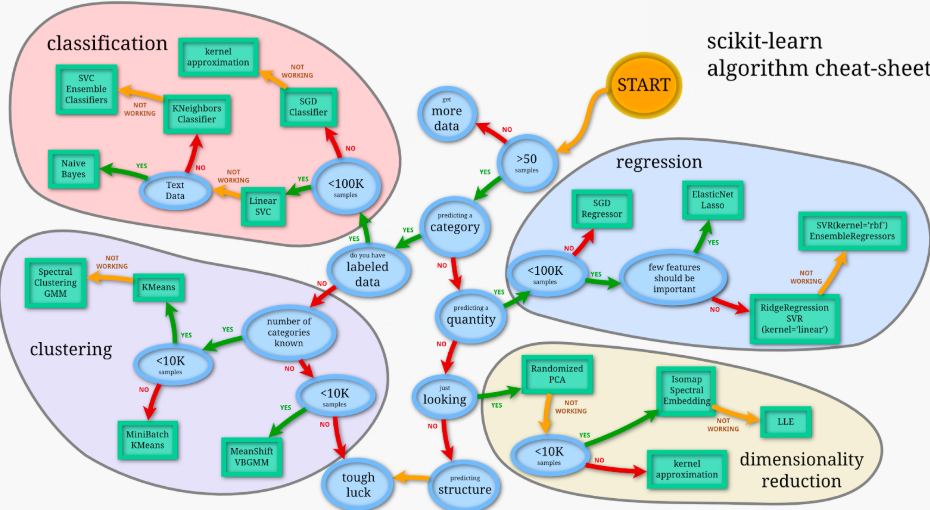

In [781]:
# function:  predict_NaN_with_ML(dfs,x,y,data_type,model)
# purpose:   predict the values of NaN and fill these predicted values back into the dataframe
# input:     dfs: the dataframe containing the features used for prediction and target y
#            x: a list of strings - features used for prediction
#            y: a string - col name 
#            data_type: a string ->'categorical','numerical'
#            model: a string 
#                 if categorical data: 'random forest','linear SVC', 'knn'
#                 if numerical data:   'random forest','SVR','knn'
# output:

def predict_NaN_with_ML(dfs,x,y,data_type,model):
    print()
    before_filling = dfs[y].dropna()
    
    # train data 
    dfs_valid_entries = dfs[dfs[y].notnull()]               # valid entries where y is not null 
    dfs_valid_entries_x = dfs_valid_entries[x]              # valid entries x
    dfs_valid_entries_y = dfs_valid_entries[y]              # valid entries y
    dfs_valid_entries_x = dfs_valid_entries_x.astype(float) # change data type to float
    dfs_valid_entries_y = dfs_valid_entries_y.astype(float)
    
    if data_type == 'categorical':
        if model == 'random forest':
            algo = RandomForestClassifier()
        elif model == 'linear SVC':
            algo = LinearSVC()
        elif model == 'knn':
            algo = KNeighborsClassifier(n_neighbors=3)
        else: 
            print('The model is not defined, add this model now!')
        print('Predict the missing values of',y,'using ',model,' Classifier...')

    else: # data_type == 'numerical' 
        if model == 'random forest':
             algo = RandomForestRegressor()
        elif model == 'SVR':
            algo = SVR()
        elif model == 'knn':
            algo = KNeighborsRegressor(n_neighbors=2)
        else: 
            print('The model is not defined, add this model now!')
        print('Predict the missing values of',y,'using ',model,' Regressor...')

    algo.fit(dfs_valid_entries_x, dfs_valid_entries_y)        # build fc model using valid entries x & y   
    
    dfs_nan_entries = dfs[dfs[y].isnull()]                    # entries where y is null     
    dfs_nan_entries_x = dfs_nan_entries[x].astype(float)    
    dfs_nan_entries_y = dfs_nan_entries[y].astype(float)
    
    predict_y = algo.predict(dfs_nan_entries_x)               # predict NaN y based on x on the same entries    
    dfs.loc[(dfs[y].isnull()), y] = predict_y                 # Fill the missing values with predicted data
    
    print('Features are:',x)
    print('The number of predicted values:',len(predict_y))
    
    after_filling = dfs[y]
    plot_before_after_fill_NaN(before_filling,after_filling,y)     
    

In [782]:
# function:  fill_NaN_with_ML_all_x(df,y,data_type,model)
# purpose:   if predict NaN in y using all processed features, use this cheat function to save typing x each time
# input:     same as -> predict_NaN_with_ML(dfs,x,y,data_type,model)
# output:    same as -> predict_NaN_with_ML(dfs,x,y,data_type,model)

def fill_NaN_with_ML_all_x(dfs,y,data_type,model):        
    dfs_cols = dfs.columns.values.tolist()
    x = dfs_cols[:dfs_cols.index(y)] 
    predict_NaN_with_ML(dfs,x,y,data_type,model)

# Load data and process data - X
- step 1: load data and describe data
- step 2: deal with missing values
- step 3: check how data changes after dealing with missing values, merge the processed dataframe to the previous dataframe


## DEMO data
#### step 1. load data and describe data

In [783]:
datadir = 'data/'
demo = pd.read_sas(datadir+'DEMO.XPT')
demo_B = pd.read_sas(datadir+'DEMO_B.XPT')
demo_C = pd.read_sas(datadir+'DEMO_C.XPT')
demo_cols = ['SEQN','RIAGENDR','RIDAGEYR', 'RIDRETH1', 'INDFMINC', 'DMDHREDU','DMDHRMAR']
demo_renamed_cols = ['SEQN', 'gender', 'age', 'race', 'family income', 'education', 'marital status']
demo_cols_type = ['SEQN','c','n','c','c','c','c']
demo_file_cols = [(demo,demo_cols),(demo_B,demo_cols),(demo_C,demo_cols)]
dfs_demo = concat_rename_dfs(demo_file_cols,demo_renamed_cols,"dfs_demo.csv")
print(dfs_demo.info())
print()
get_value_count(dfs_demo,demo_renamed_cols,demo_cols_type)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 31126 entries, 1.0 to 31126.0
Data columns (total 6 columns):
gender            31126 non-null float64
age               31126 non-null float64
race              31126 non-null float64
family income     30593 non-null float64
education         30030 non-null float64
marital status    28487 non-null float64
dtypes: float64(6)
memory usage: 1.7 MB
None



NaN    0
2.0    15942
1.0    15184
Name: gender, dtype: int64

count    31126.000000
mean        29.669440
std         25.019183
min          0.000000
25%         10.000000
50%         19.000000
75%         48.000000
max         85.000000
Name: age, dtype: float64

NaN    0
3.0    12106
1.0     8688
4.0     7572
2.0     1447
5.0     1313
Name: race, dtype: int64

NaN    533
11.0    4313
6.0     3486
3.0     3303
4.0     2740
5.0     2721
7.0     2616
2.0     2408
8.0     2196
1.0     1760
9.0     1530
10.0    1189
12.0     763
13.0     666
77.0     482
99.0     420
Name: family income,

#### step 2. Data modification and Fill NaN
- Need to convert nominal variables: Gender to dummies; education and marital status have too many states, if all are converted to dummies, then the number of features would be too many(risk of overfitting)
- Based on dfs_demo.info(), gender, age, race don't have any missing values. Proceed to deal with missing values in family income, education, and marital status. Keep all (don't know) and (refuse to answer) for now since they contain information. Fill NaN with mode here since these 3 are all categorical data and fill with mean doesn't make sense. The distribution shows direct filling NaN with mode makes sense since no drastic change in distribution is observed.


In [784]:
# No NaN in gender and race, convert these two to dummies directly
dfs_demo = convert_nominal_to_dummies(dfs_demo,'gender',['male','female'])
dfs_demo.head()

,age,race,family income,education,marital status,male,female
SEQN,,,,,,,
1.0,2.0,4.0,3.0,3.0,5.0,0,1
2.0,77.0,3.0,8.0,5.0,NaN,1,0
3.0,10.0,3.0,6.0,4.0,1.0,0,1
4.0,1.0,4.0,3.0,3.0,4.0,1,0
5.0,49.0,3.0,11.0,4.0,1.0,1,0



The ratio of [dont know] is 0.015
The ratio of [refuse] is 0.013
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in family income is 0.046
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  family income is  29691
after filling NaN, valid entries of  family income is  31126

The ratio of [dont know] is 0.001
The ratio of [refuse] is 0.005
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in education is 0.042
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  education is  29828
after filling NaN, valid entries of  education is  31126


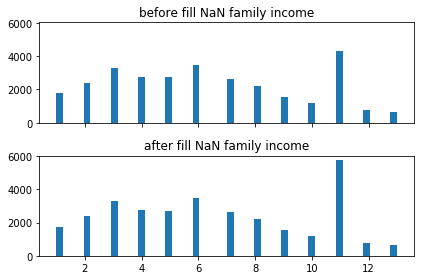

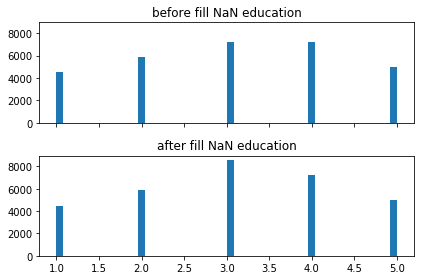

In [785]:
get_79_ratio(dfs_demo,'family income',[77,99])
dfs_demo = process_79(dfs_demo,'family income',[77,99],'NaN')
get_NaN_ratio_for_one_col(dfs_demo,'family income')
dfs_demo = fill_NaN(dfs_demo,'family income','mode') 

get_79_ratio(dfs_demo,'education',[7,9])
dfs_demo = process_79(dfs_demo,'education',[7,9],'NaN')
get_NaN_ratio_for_one_col(dfs_demo,'education')
dfs_demo = fill_NaN(dfs_demo,'education','mode') 



The ratio of [dont know] is 0.003
The ratio of [refuse] is 0.001
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in marital status is 0.089
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  marital status is  28367
after filling NaN, valid entries of  marital status is  31126


,age,race,family income,education,marital status,male,female
SEQN,,,,,,,
1.0,2.0,4.0,3.0,3.0,5.0,0,1
2.0,77.0,3.0,8.0,5.0,1.0,1,0
3.0,10.0,3.0,6.0,4.0,1.0,0,1
4.0,1.0,4.0,3.0,3.0,4.0,1,0
5.0,49.0,3.0,11.0,4.0,1.0,1,0


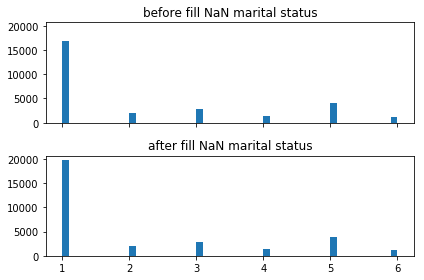

In [786]:
get_79_ratio(dfs_demo,'marital status',[77,99])
dfs_demo = process_79(dfs_demo,'marital status',[77,99],'NaN')
get_NaN_ratio_for_one_col(dfs_demo,'marital status')
dfs_demo = fill_NaN(dfs_demo,'marital status','mode')
dfs_demo.head()

#### step 3: check how data changes after dealing with missing values

In [787]:
dfs_demo.info()
dfs_demo.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 31126 entries, 1.0 to 31126.0
Data columns (total 7 columns):
age               31126 non-null float64
race              31126 non-null float64
family income     31126 non-null float64
education         31126 non-null float64
marital status    31126 non-null float64
male              31126 non-null uint8
female            31126 non-null uint8
dtypes: float64(5), uint8(2)
memory usage: 1.5 MB


,age,race,family income,education,marital status,male,female
SEQN,,,,,,,
1.0,2.0,4.0,3.0,3.0,5.0,0,1
2.0,77.0,3.0,8.0,5.0,1.0,1,0
3.0,10.0,3.0,6.0,4.0,1.0,0,1
4.0,1.0,4.0,3.0,3.0,4.0,1,0
5.0,49.0,3.0,11.0,4.0,1.0,1,0


## Alcohol data
#### step 1. load data and describe data

In [788]:
alco = pd.read_sas(datadir+'ALQ.XPT')
alco_B = pd.read_sas(datadir+'ALQ_B.XPT')
alco_C = pd.read_sas(datadir+'ALQ_C.XPT')
alco_cols = ['SEQN', 'ALQ100', 'ALQ120Q', 'ALQ120U']
alco_B_cols = ['SEQN', 'ALD100', 'ALQ120Q', 'ALQ120U']
alco_C_cols = ['SEQN', 'ALQ101', 'ALQ120Q', 'ALQ120U']
alco_renamed_cols = ['SEQN','freq:12 drinks/yr?','alco_freq_num','alco_freq_cat']
alco_cols_type = ['SEQN','c','n','c']
alco_file_cols = [(alco,alco_cols),(alco_B,alco_B_cols),(alco_C,alco_C_cols)]
dfs_alco = concat_rename_dfs(alco_file_cols,alco_renamed_cols,"dfs_alco.csv")
dfs_alco.info()
get_value_count(dfs_alco,alco_renamed_cols,alco_cols_type)
dfs_alco.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 14213 entries, 2.0 to 31125.0
Data columns (total 3 columns):
freq:12 drinks/yr?    13094 non-null float64
alco_freq_num         11094 non-null float64
alco_freq_cat         8325 non-null float64
dtypes: float64(3)
memory usage: 444.2 KB


NaN    1119
1.0    8847
2.0    4242
9.0       5
Name: freq:12 drinks/yr?, dtype: int64

count    11094.000000
mean         5.290247
std         38.080096
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        999.000000
Name: alco_freq_num, dtype: float64

NaN    5888
1.0    3400
3.0    2877
2.0    2048
Name: alco_freq_cat, dtype: int64


,freq:12 drinks/yr?,alco_freq_num,alco_freq_cat
SEQN,,,
2.0,1.0,24.0,3.0
5.0,1.0,4.0,1.0
7.0,2.0,NaN,NaN
10.0,1.0,6.0,3.0
12.0,1.0,2.0,2.0


In [789]:
# df1 = dfs_demo + dfs_alco 
df1 = pd.merge(dfs_demo, dfs_alco, on = 'SEQN', left_index = True, sort = False)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 14213 entries, 2.0 to 31125.0
Data columns (total 10 columns):
age                   14213 non-null float64
race                  14213 non-null float64
family income         14213 non-null float64
education             14213 non-null float64
marital status        14213 non-null float64
male                  14213 non-null uint8
female                14213 non-null uint8
freq:12 drinks/yr?    13094 non-null float64
alco_freq_num         11094 non-null float64
alco_freq_cat         8325 non-null float64
dtypes: float64(8), uint8(2)
memory usage: 1.0 MB


#### step 2. Fill NaN
- 'freq:12 drinks/yr?': NaN ratio is small, assign NaN as a new category with code 0, (check out function -> fill_NaN(dfs, col_name, fill_type))
- 'alco_freq_num': NaN ratio is large, use ML to predict, need to decide what features to use when predicting. 


The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.000
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in freq:12 drinks/yr? is 0.079
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  freq:12 drinks/yr? is  13089
after filling NaN, valid entries of  freq:12 drinks/yr? is  14208


1.0    8847
2.0    4242
0.0    1119
Name: freq:12 drinks/yr?, dtype: int64

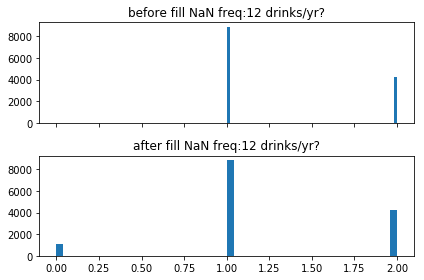

In [790]:
get_79_ratio(df1,'freq:12 drinks/yr?',[7,9])
df1 = process_79(df1,'freq:12 drinks/yr?',[7,9],'drop')
get_NaN_ratio_for_one_col(dfs_alco,'freq:12 drinks/yr?')
df1 = fill_NaN(df1,'freq:12 drinks/yr?','zero')
df1['freq:12 drinks/yr?'].value_counts()

- deal with ALQ120Q & 120U.
- ALQ120Q: alco_freq_num - How often drink alcohol over past 12 mos
- ALQ120U: alco_freq_cat - # days drink alcohol per wk, mo, yr (1:week,2:month,3:year)

Combine these two variables into one variable: 
- alco_freq_year: the number of days that you drink in a year

        1 - week:   ALQ120Q * 54.143 (weeks/yr)
        2 - month:  ALQ120Q * 12     (months/yr)
        3 - year:   ALQ120Q * 1

After converting to the same scale, we then predict this new feature [alco_freq_year] using [freq:12 drinks/yr?].


In [791]:
get_79_ratio(df1,'alco_freq_num',[777,999])
df1 = process_79(df1,'alco_freq_num',[777,999],'drop')
df1['alco freq year'] = 0

for SEQN,category in df1['alco_freq_cat'].iteritems():
    alco_freq_num = df1.loc[SEQN]['alco_freq_num']
    if category == 1:   # week
        drinks = alco_freq_num * (365/7)
    elif category == 2: # month 
        drinks = alco_freq_num * (12)
    elif category == 3: # year
        drinks = alco_freq_num
    else:              # NaN: doing nothing for now
        drinks = None
    df1.set_value(SEQN,'alco freq year',drinks)
    

df1 = df1.drop(['alco_freq_num','alco_freq_cat'], axis=1)
df1.info()
df1.head()


The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.001
Now call: process_79(dfs,col_name,cstr,method)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 14198 entries, 2.0 to 31125.0
Data columns (total 9 columns):
age                   14198 non-null float64
race                  14198 non-null float64
family income         14198 non-null float64
education             14198 non-null float64
marital status        14198 non-null float64
male                  14198 non-null uint8
female                14198 non-null uint8
freq:12 drinks/yr?    14198 non-null float64
alco freq year        8324 non-null float64
dtypes: float64(7), uint8(2)
memory usage: 1.5 MB


,age,race,family income,education,marital status,male,female,freq:12 drinks/yr?,alco freq year
SEQN,,,,,,,,,
2.0,77.0,3.0,8.0,5.0,1.0,1,0,1.0,24.0
5.0,49.0,3.0,11.0,4.0,1.0,1,0,1.0,208.0
7.0,59.0,4.0,11.0,2.0,1.0,0,1,2.0,NaN
10.0,43.0,4.0,11.0,3.0,4.0,1,0,1.0,6.0
12.0,37.0,3.0,11.0,2.0,1.0,1,0,1.0,24.0


??? The distribution of 'alco_freq_year' skews significantly towards low frequency after prediction. Need a better way for prediction? 


Checking for predictability...
x:  ['age' 'race' 'family income' 'education' 'marital status' 'male' 'female'
 'freq:12 drinks/yr?']
y:  alco freq year

Using Linear Regression...
Coefficients for x:  [  1.05950194   6.39075606   1.46082216   3.28994506   3.11192843
  18.6541017  -18.6541017  -68.8361428 ]
Intercept Value: 56.73757360842609 Mean squared error: 9489.351296506124 R^2: 0.1331043233321132

If the correlation is weak, try predict y using some x instead of all
Call function: check_predictability_some_x(dfs,x,y,method) with chosen x

Predict the missing values of alco freq year using  random forest  Regressor...
Features are: ['age', 'race', 'education', 'marital status', 'male', 'female', 'freq:12 drinks/yr?']
The number of predicted values: 5874

before filling NaN, valid entries of  alco freq year is  8324
after filling NaN, valid entries of  alco freq year is  14198
<class 'pandas.core.frame.DataFrame'>
Float64Index: 14198 entries, 2.0 to 31125.0
Data columns (total 9 co

count    14198.000000
mean        62.533089
std         90.541295
min          1.000000
25%          4.000000
50%         24.000000
75%         87.816071
max        365.000000
Name: alco freq year, dtype: float64

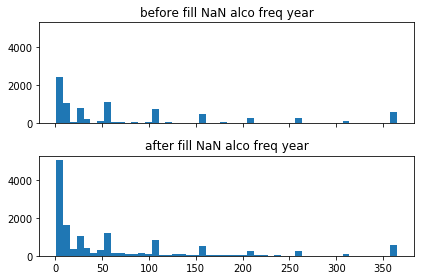

In [792]:
check_predictability_all_x(df1,'alco freq year','linear regression')
predict_NaN_with_ML(df1,['age','race','education','marital status','male','female','freq:12 drinks/yr?'],'alco freq year','numerical','random forest')
df1.info()
df1['alco freq year'].describe()

## Pain Killers (PK)
#### step 1. load data and describe data

In [793]:
# Load PK data
RXQANA = pd.read_sas(datadir+'RXQ_ANA.XPT')
RXQANA_B = pd.read_sas(datadir+'RXQANA_B.XPT')
RXQANA_C = pd.read_sas(datadir+'RXQANA_C.XPT')

PK_cols = ['SEQN', 'RXQ300', 'RXQ330']
PK_B_cols = ['SEQN', 'RXD300', 'RXD330']
PK_C_cols = ['SEQN', 'RXD300', 'RXD330']
PK_renamed_cols = ['SEQN', 'regular PK use', 'current PK use']
PK_cols_type = ['SEQN','c','c']

PK_file_cols = [(RXQANA,PK_cols),(RXQANA_B,PK_B_cols),(RXQANA_C,PK_C_cols)]
dfs_pk = concat_rename_dfs(PK_file_cols,PK_renamed_cols,"dfs_pk.csv")
print(dfs_pk.info())
get_value_count(dfs_pk,PK_renamed_cols,PK_cols_type)
dfs_pk.head()


<class 'pandas.core.frame.DataFrame'>
Float64Index: 15332 entries, 2.0 to 31125.0
Data columns (total 2 columns):
regular PK use    15316 non-null float64
current PK use    3581 non-null float64
dtypes: float64(2)
memory usage: 359.3 KB
None


NaN    16
2.0    11690
1.0     3592
7.0       24
9.0       10
Name: regular PK use, dtype: int64

NaN    11751
1.0    2364
2.0    1210
9.0       6
7.0       1
Name: current PK use, dtype: int64


,regular PK use,current PK use
SEQN,,
2.0,1.0,1.0
5.0,2.0,NaN
7.0,2.0,NaN
10.0,1.0,1.0
12.0,1.0,2.0


#### step 2. Fill NaN
- regular PK use: Missing values is not significant, direct fill with mode
- current PK use: NaN ratio is significant! 


The ratio of [dont know] is 0.001
The ratio of [refuse] is 0.000
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in regular PK use is 0.002
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  regular PK use is  14172
after filling NaN, valid entries of  regular PK use is  14198


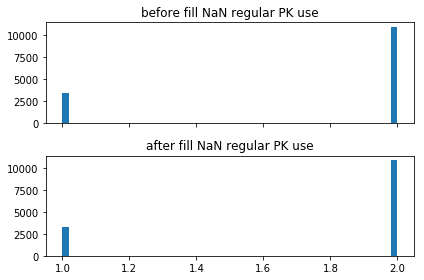

In [794]:
# df2 = df1 + dfs_pk = (dfs_demo + dfs_alco) + dfs_pk
df2 = pd.merge(df1, dfs_pk, on = 'SEQN', left_index =  True, sort = False)
get_79_ratio(df2,'regular PK use',[7,9])
df2 = process_79(df2,'regular PK use',[7,9],'NaN')
get_NaN_ratio_for_one_col(df2,'regular PK use')
df2 = fill_NaN(df2,'regular PK use','mode')


The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.000
Now call: process_79(dfs,col_name,cstr,method)

Checking for predictability...
x:  ['age' 'race' 'family income' 'education' 'marital status' 'male' 'female'
 'freq:12 drinks/yr?' 'alco freq year' 'regular PK use']
y:  current PK use

Using Linear Regression...
Coefficients for x:  [-7.75237428e-03  6.74214223e-03  3.17402231e-04  6.19412678e-03
  1.71272623e-02 -9.29915042e-03  9.29915042e-03  1.39936045e-02
 -6.24249023e-05  0.00000000e+00]
Intercept Value: 1.7236543380300884 Mean squared error: 0.20412160777835311 R^2: 0.09072703353556755

If the correlation is weak, try predict y using some x instead of all
Call function: check_predictability_some_x(dfs,x,y,method) with chosen x

Predict the missing values of current PK use using  random forest  Classifier...
Features are: ['regular PK use']
The number of predicted values: 10879

before filling NaN, valid entries of  current PK use is  3312
after filling NaN, valid e

,age,race,family income,education,marital status,male,female,freq:12 drinks/yr?,alco freq year,regular PK use,current PK use
SEQN,,,,,,,,,,,
2.0,77.0,3.0,8.0,5.0,1.0,1,0,1.0,24.000000,1.0,1.0
5.0,49.0,3.0,11.0,4.0,1.0,1,0,1.0,208.000000,2.0,1.0
7.0,59.0,4.0,11.0,2.0,1.0,0,1,2.0,42.514286,2.0,1.0
10.0,43.0,4.0,11.0,3.0,4.0,1,0,1.0,6.000000,1.0,1.0
12.0,37.0,3.0,11.0,2.0,1.0,1,0,1.0,24.000000,1.0,2.0


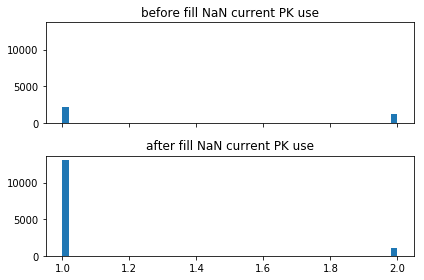

In [795]:
get_79_ratio(df2,'current PK use',[7,9])
df2 = process_79(df2,'current PK use',[7,9],'drop')
check_predictability_all_x(df2,'current PK use','linear regression')
predict_NaN_with_ML(df2,['regular PK use'],'current PK use','categorical','random forest')
df2.info()
df2.head()

- Create a new variable named pk_use combining regular and current pk use:
To see what combinations of regular and current pk uses are possible, check for possible values in both cols

In [796]:
print('unique values in regular PK use:', df2['regular PK use'].unique())
print('unique values in current PK use:', df2['current PK use'].unique())

unique values in regular PK use: [1. 2.]
unique values in current PK use: [1. 2.]


- code words for the new variable pk use: 

| Regular pk use | Current pk use | pk use | pk use code explanation                             |
|----------------|----------------|--------|-----------------------------------------------------|
| yes 1          | yes 1          | 1      | take both regularly in the past and the present     |
| yes 1          | no 2           | 2      | taken regularly in the past but not in the present  |
| no 2           | yes 1          | 3      | didn't take regularly in the past but is taking now |
| no 2           | no 2           | 4      | never take the pain killers                         |

* note for the last row in the table: if either of regular or current pk use contains 7 or 9, assign 5 as pk use

In [797]:
for SEQN,row in df2.iterrows():
    regular = row['regular PK use']
    current = row['current PK use']
    if regular == 1 and current == 1:
        pk_use = 1
    elif regular == 1 and current == 2:
        pk_use = 2
    elif regular == 2 and current == 1:
        pk_use = 3
    elif regular == 2 and current == 2:
        pk_use = 4
    else:
        print('THIS SHOULD NOT APPEAR') 
    df2.set_value(SEQN,'pk use',pk_use)

In [798]:
df2 = df2.drop(['regular PK use','current PK use'], axis=1)
df2['pk use'].value_counts()

3.0    10872
1.0     2192
2.0     1127
Name: pk use, dtype: int64

Notice: there's no 4 in column 'pk use'. ???

## Blood Pressure(BP) & Blood Cholesterol(BC)

1. Modification: change 'ever check BC' to 'told if has high BC'
2. Physiologically, high cholesterol level(blood vessel narrowing due to plaque buildup) could lead to high blood pressure, but this is not always the case. It's better to treat these two as two separate variables for now.
3. Group weight control (now controlling weight) and weight control own (controlling weight on own will) into one variable. Same for increasing exercise and taking medicines. 

#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 18891 entries, 2.0 to 31125.0
Data columns (total 9 columns):
high BP               18623 non-null float64
high BC               10284 non-null float64
take med              2157 non-null float64
low cal diet          3257 non-null float64
weight control        2147 non-null float64
inc exercise          2583 non-null float64
low cal diet own      11315 non-null float64
weight control own    11315 non-null float64
inc exercise own      11315 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


NaN    268
2.0    13570
1.0     5014
9.0       39
Name: high BP, dtype: int64

NaN    8607
2.0    6176
1.0    4012
9.0      95
7.0       1
Name: high BC, dtype: int64

NaN    16734
1.0    1720
2.0     437
Name: take med, dtype: int64

NaN    15634
1.0    2659
2.0     596
9.0       2
Name: low cal diet, dtype: int64

NaN    16744
1.0    1665
2.0     480
9.0       2
Name: weight control, dtype: int64

NaN    16308
1.0    1782
2.0     801
Nam

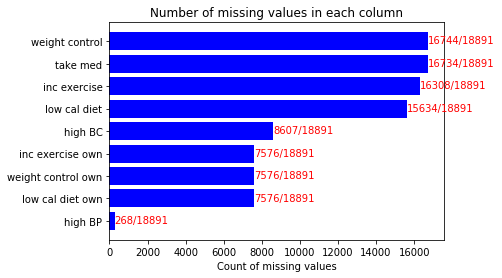

,high BP,high BC,take med,low cal diet,weight control,inc exercise,low cal diet own,weight control own,inc exercise own
SEQN,,,,,,,,,
2.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0
5.0,1.0,1.0,NaN,1.0,2.0,1.0,NaN,NaN,NaN
6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
10.0,2.0,NaN,NaN,NaN,NaN,NaN,9.0,9.0,9.0


In [799]:
# Load BP data
BPQ = pd.read_sas(datadir+'BPQ.XPT')
BPQ_B = pd.read_sas(datadir+'BPQ_B.XPT')
BPQ_C = pd.read_sas(datadir+'BPQ_C.XPT')
col_1 = ['SEQN', 'BPQ020', 'BPQ080', 'BPQ100D','BPQ100A', 'BPQ100B','BPQ100C', 'BPQ110A', 'BPQ110B', 'BPQ110C']
col_2 = ['SEQN', 'BPQ020', 'BPQ080', 'BPQ100D','BPQ100A', 'BPQ100B','BPQ100C', 'BPD110A', 'BPD110B', 'BPD110C']
BPQ_renamed_cols = ['SEQN','high BP','high BC','take med','low cal diet','weight control','inc exercise','low cal diet own','weight control own','inc exercise own']
BPQ_cols_type = ['SEQN','c','c','c','c','c','c','c','c','c']
BPQ_file_cols = [(BPQ,col_1),(BPQ_B,col_2),(BPQ_C,col_2)]
dfs_bp = concat_rename_dfs(BPQ_file_cols,BPQ_renamed_cols,"dfs_bp.csv")
dfs_bp.info()
get_value_count(dfs_bp,BPQ_renamed_cols,BPQ_cols_type)
plot_NaN_abundance_for_all_cols(dfs_bp)
dfs_bp.head()


#### step 2. Fill NaN
- high BP: NaN ratio is small, direct fill NaN 	
- high BC: first check correlation between BP and BC using cramers_v (for two categorical variables), the correlation is not very strong. Can't group them as one. Predict BC with ML rf. ??? Distribution after filling NaN skews towards 2	


The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.002
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in high BP is 0.011
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  high BP is  14034
after filling NaN, valid entries of  high BP is  14191

The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.006
Now call: process_79(dfs,col_name,cstr,method)

The NaN ratio in high BC is 0.337
Since NaN ratio is large, predict NaN using ML or check predictability first...
if check predictability, call: check_predictability_all/some_x(dfs,y,method)
if predict using ML, call: predict_NaN_with_ML(dfs,x,y,data_type,model)
Using Cramers_v...
Cramers_v value between high BP and high BC is 0.20453074036996918

Predict the missing values of high BC using  random forest  Classifier...
Features are: ['age', 'race', 'family income', 'education', 'ma

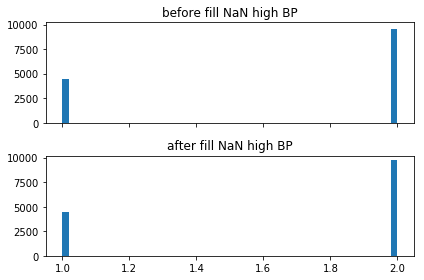

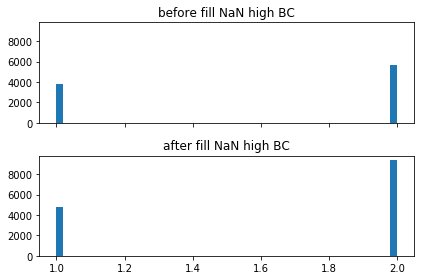

In [800]:
# df3 = df1 + df2 + df3 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp
df3 = pd.merge(df2, dfs_bp, on = 'SEQN', left_index =  True, sort = False)

get_79_ratio(df3,'high BP',[7,9])
df3 = process_79(df3,'high BP',[7,9],'NaN')
get_NaN_ratio_for_one_col(df3,'high BP')
df3 = fill_NaN(df3,'high BP','mode')

get_79_ratio(df3,'high BC',[7,9])
df3 = process_79(df3,'high BC',[7,9],'NaN')
get_NaN_ratio_for_one_col(df3,'high BC')
df_temp = df3[['high BP','high BC']].dropna()
x = df_temp['high BP']
y = df_temp['high BC']
cramers_v(x,y)
fill_NaN_with_ML_all_x(df3,'high BC','categorical','random forest')

These variables all have large ratios of NaN. Predict NaN with ML rf first.
- take med: 	
- low cal diet	
- weight control	
- inc exercise	
- low cal diet own	
- weight control own	
- inc exercise own


Checking for predictability...
x:  ['age' 'race' 'family income' 'education' 'marital status' 'male' 'female'
 'freq:12 drinks/yr?' 'alco freq year' 'pk use' 'high BP' 'high BC']
y:  take med

Using Linear Regression...
Coefficients for x:  [-0.00465175 -0.02011755 -0.00122715 -0.01761003 -0.00318489 -0.03311447
  0.03311447 -0.00282908  0.00015102  0.03072155  0.0925089   0.        ]
Intercept Value: 1.4307052625143113 Mean squared error: 0.1544106265423198 R^2: 0.057947396524198

If the correlation is weak, try predict y using some x instead of all
Call function: check_predictability_some_x(dfs,x,y,method) with chosen x

Predict the missing values of take med using  random forest  Classifier...
Features are: ['age', 'alco freq year', 'pk use', 'high BP', 'high BC']
The number of predicted values: 12187

before filling NaN, valid entries of  take med is  2004
after filling NaN, valid entries of  take med is  14191


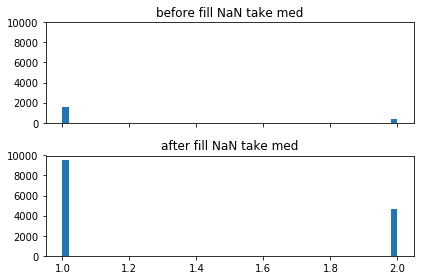

In [801]:
check_predictability_all_x(df3,'take med','linear regression')
predict_NaN_with_ML(df3,['age','alco freq year','pk use','high BP','high BC'],'take med','categorical','random forest')


The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.000
Now call: process_79(dfs,col_name,cstr,method)

Predict the missing values of low cal diet using  random forest  Classifier...
Features are: ['age', 'high BP', 'high BC']
The number of predicted values: 11138

before filling NaN, valid entries of  low cal diet is  3052
after filling NaN, valid entries of  low cal diet is  14190


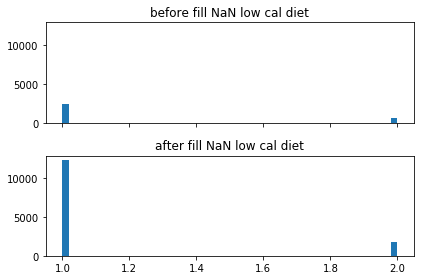

In [802]:
get_79_ratio(df3,'low cal diet',[7,9])
df3 = process_79(df3,'low cal diet',[7,9],'drop')
predict_NaN_with_ML(df3,['age','high BP','high BC'],'low cal diet','categorical','random forest')


The ratio of [dont know] is 0.000
The ratio of [refuse] is 0.000
Now call: process_79(dfs,col_name,cstr,method)

Predict the missing values of weight control using  random forest  Classifier...
Features are: ['age', 'male', 'female', 'high BP', 'high BC', 'low cal diet']
The number of predicted values: 12157

before filling NaN, valid entries of  weight control is  2032
after filling NaN, valid entries of  weight control is  14189


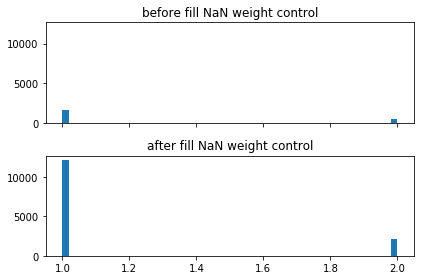

In [803]:
get_79_ratio(df3,'weight control',[7,9])
df3 = process_79(df3,'weight control',[7,9],'drop')
predict_NaN_with_ML(df3,['age','male','female','high BP','high BC','low cal diet'],'weight control','categorical','random forest')


Predict the missing values of inc exercise using  random forest  Classifier...
Features are: ['age', 'high BP', 'high BC', 'low cal diet', 'weight control']
The number of predicted values: 11750

before filling NaN, valid entries of  inc exercise is  2439
after filling NaN, valid entries of  inc exercise is  14189


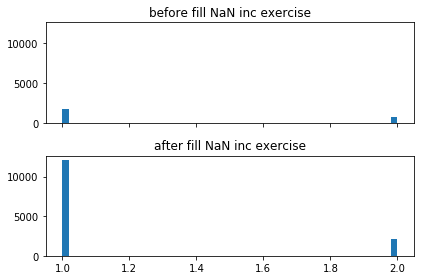

In [804]:
predict_NaN_with_ML(df3,['age','high BP','high BC','low cal diet','weight control'],'inc exercise','categorical','random forest')


Predict the missing values of low cal diet own using  random forest  Classifier...
Features are: ['age', 'high BP', 'high BC', 'low cal diet', 'weight control', 'inc exercise']
The number of predicted values: 3757

before filling NaN, valid entries of  low cal diet own is  10422
after filling NaN, valid entries of  low cal diet own is  14179

Predict the missing values of weight control own using  random forest  Classifier...
Features are: ['age', 'high BP', 'high BC', 'low cal diet', 'weight control', 'inc exercise', 'low cal diet own']
The number of predicted values: 3757

before filling NaN, valid entries of  weight control own is  10415
after filling NaN, valid entries of  weight control own is  14172

Predict the missing values of inc exercise own using  random forest  Classifier...
Features are: ['age', 'high BP', 'high BC', 'low cal diet', 'weight control', 'inc exercise', 'low cal diet own', 'weight control own']
The number of predicted values: 3757

before filling NaN, valid 

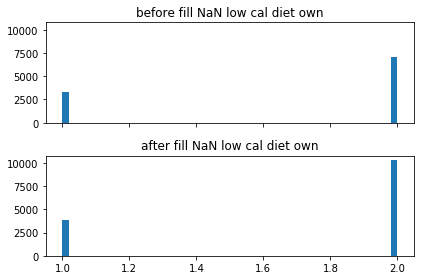

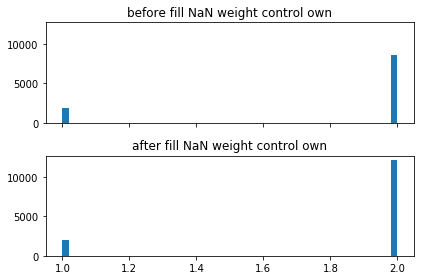

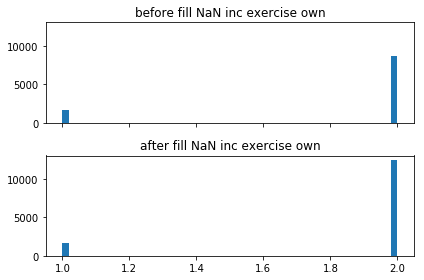

In [805]:
df3 = process_79(df3,'low cal diet own',[7,9],'drop')
predict_NaN_with_ML(df3,['age','high BP','high BC','low cal diet','weight control','inc exercise'],'low cal diet own','categorical','random forest')
df3 = process_79(df3,'weight control own',[7,9],'drop')
predict_NaN_with_ML(df3,['age','high BP','high BC','low cal diet','weight control','inc exercise','low cal diet own'],'weight control own','categorical','random forest')
df3 = process_79(df3,'inc exercise own',[7,9],'drop')
predict_NaN_with_ML(df3,['age','high BP','high BC','low cal diet','weight control','inc exercise','low cal diet own','weight control own'],'inc exercise own','categorical','random forest')

Group related variables: 

- low cal diet + low cal diet own = diet status
- weight control + weight control own = weight control status
- inc exercise + inc exercise own = exercise status

For each status, the first component means the current behavior of the subject. The second component (own) means that the doctor informs the subject to conduct certain behavior, and the response of the subject given doctor's instruction. If either component is 1(YES), then it means the subject is conducting this behavior.

In [806]:
def BP_group_variables(dfs,new_v,old_v1,old_v2):
    dfs[new_v] = 2 
    dfs[new_v][dfs[old_v1] == 1] = 1
    dfs[new_v][dfs[old_v2] == 1] = 1
    dfs = dfs.drop([old_v1,old_v2], axis=1)
    return dfs

df3_1 = BP_group_variables(df3,'diet status','low cal diet','low cal diet own')
df3_2 = BP_group_variables(df3_1,'weight control status','weight control','weight control own')
df3_3 = BP_group_variables(df3_2,'exercise status','inc exercise','inc exercise own')
df3 = df3_3

### Diabetes (db)

#### step 1. load data and describe data

In [807]:
DIQ = pd.read_sas(datadir+'DIQ.XPT')
DIQ_B = pd.read_sas(datadir+'DIQ_B.XPT')
DIQ_C = pd.read_sas(datadir+'DIQ_C.XPT')
db_cols = ['SEQN','DIQ010']
db_renamed_cols = ['SEQN','diabetes status']
db_cols_type = ['SEQN','c']
db_file_cols = [(DIQ,db_cols),(DIQ_B,db_cols),(DIQ_C,db_cols)]
dfs_db = concat_rename_dfs(db_file_cols,db_renamed_cols,"dfs_db.csv")
dfs_db.info()
get_value_count(dfs_db,db_renamed_cols,db_cols_type)
dfs_db.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29608 entries, 1.0 to 31126.0
Data columns (total 1 columns):
diabetes status    29601 non-null float64
dtypes: float64(1)
memory usage: 462.6 KB


NaN    7
2.0    27798
1.0     1576
3.0      214
9.0       12
7.0        1
Name: diabetes status, dtype: int64


,diabetes status
SEQN,
1.0,2.0
2.0,2.0
3.0,2.0
4.0,2.0
5.0,2.0


#### step 2. Fill NaN
- diabetes status: Missing values are very few, direct fill


before filling NaN, valid entries of  diabetes status is  14163
after filling NaN, valid entries of  diabetes status is  14165


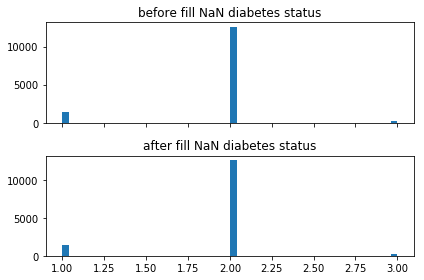

In [808]:
# df4 = df1 + df2 + df3 + dfs_db = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db
df4 = pd.merge(df3, dfs_db, on = 'SEQN', left_index =  True, sort = False)
df4 = process_79(df4,'diabetes status',[7,9],'drop')
df4 = fill_NaN(df4,'diabetes status','mode') 


### Drug Use (du)

#### step 1. load data and describe data

In [809]:
# Load drug use data
DUQ = pd.read_sas(datadir+'DUQ.XPT')
DUQ_B = pd.read_sas(datadir+'DUQ_B.XPT')
DUQ_C = pd.read_sas(datadir+'DUQ_C.XPT')
du_cols = ['SEQN', 'DUQ100']
du_renamed_cols = ['SEQN','ever use cocaine']
du_cols_type = ['SEQN','c']
du_file_cols = [(DUQ,du_cols),(DUQ_B,du_cols),(DUQ_C,du_cols)]
dfs_du = concat_rename_dfs(du_file_cols,du_renamed_cols,"dfs_du.csv")
dfs_du.info()
get_value_count(dfs_du,du_renamed_cols,du_cols_type)
dfs_du.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9229 entries, 5.0 to 31125.0
Data columns (total 1 columns):
ever use cocaine    8300 non-null float64
dtypes: float64(1)
memory usage: 144.2 KB


NaN    929
2.0    6631
1.0    1639
9.0      16
7.0      14
Name: ever use cocaine, dtype: int64


,ever use cocaine
SEQN,
5.0,2.0
7.0,2.0
10.0,2.0
12.0,1.0
15.0,2.0


#### step 2. Fill NaN
- ever use cocaine


The NaN ratio in ever use cocaine is 0.104
Since NaN ratio is large, predict NaN using ML or check predictability first...
if check predictability, call: check_predictability_all/some_x(dfs,y,method)
if predict using ML, call: predict_NaN_with_ML(dfs,x,y,data_type,model)

Predict the missing values of ever use cocaine using  knn  Classifier...
Features are: ['age', 'race', 'family income', 'education', 'marital status', 'male', 'female', 'freq:12 drinks/yr?', 'alco freq year', 'pk use', 'high BP', 'high BC', 'take med', 'diet status', 'weight control status', 'exercise status', 'diabetes status']
The number of predicted values: 953

before filling NaN, valid entries of  ever use cocaine is  8248
after filling NaN, valid entries of  ever use cocaine is  9201


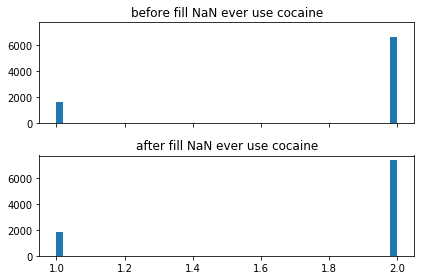

In [810]:
# df5 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du
df5 = pd.merge(df4, dfs_du, on = 'SEQN', left_index =  True, sort = False)
df5 = process_79(df5,'ever use cocaine',[7,9],'NaN')
get_NaN_ratio_for_one_col(df5,'ever use cocaine')
fill_NaN_with_ML_all_x(df5,'ever use cocaine','categorical','knn')

### Hospital Utilization & Access to Care (HUAC)

#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 31126 entries, 1.0 to 31126.0
Data columns (total 3 columns):
health conditions                31121 non-null float64
health compared to a year ago    29602 non-null float64
visit to mental pro              27110 non-null float64
dtypes: float64(3)
memory usage: 972.7 KB


NaN    5
1.0    10003
3.0     8557
2.0     7854
4.0     3790
5.0      903
9.0        8
7.0        6
Name: health conditions, dtype: int64

NaN    1524
3.0    21841
1.0     5462
2.0     2288
9.0        9
7.0        2
Name: health compared to a year ago, dtype: int64

NaN    4016
2.0    25106
1.0     1981
9.0       19
7.0        4
Name: visit to mental pro, dtype: int64


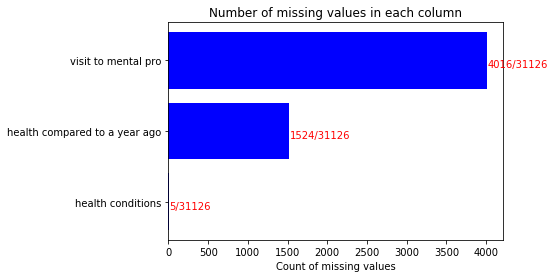

,health conditions,health compared to a year ago,visit to mental pro
SEQN,,,
1.0,1.0,3.0,NaN
2.0,2.0,2.0,2.0
3.0,1.0,1.0,2.0
4.0,1.0,3.0,NaN
5.0,2.0,3.0,2.0


In [811]:
HUQ = pd.read_sas(datadir+'HUQ.XPT')
HUQ_B = pd.read_sas(datadir+'HUQ_B.XPT')
HUQ_C = pd.read_sas(datadir+'HUQ_C.XPT')
huac_cols = ['SEQN', 'HUQ010', 'HUQ020', 'HUQ090']
huac_renamed_cols = ['SEQN', 'health conditions', 'health compared to a year ago', 'visit to mental pro']
huac_cols_type = ['SEQN','c','c','c']
huac_file_cols = [(HUQ,huac_cols),(HUQ_B,huac_cols),(HUQ_C,huac_cols)]
dfs_huac = concat_rename_dfs(huac_file_cols,huac_renamed_cols,"dfs_huac.csv")

dfs_huac.info()
get_value_count(dfs_huac,huac_renamed_cols,huac_cols_type)
plot_NaN_abundance_for_all_cols(dfs_huac)
dfs_huac.head()

#### step 2. Fill NaN
After joining to df6, only one missing value in each of the three variables. Direct fill
- health conditions
- health compared to a year ago
- visit to mental pro


before filling NaN, valid entries of  health conditions is  9196
after filling NaN, valid entries of  health conditions is  9197

before filling NaN, valid entries of  health compared to a year ago is  9196
after filling NaN, valid entries of  health compared to a year ago is  9197

before filling NaN, valid entries of  visit to mental pro is  9191
after filling NaN, valid entries of  visit to mental pro is  9192


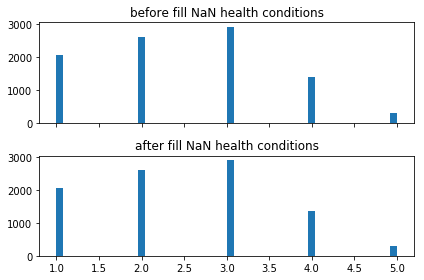

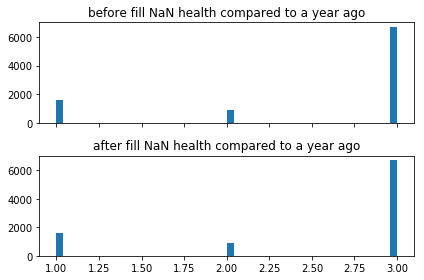

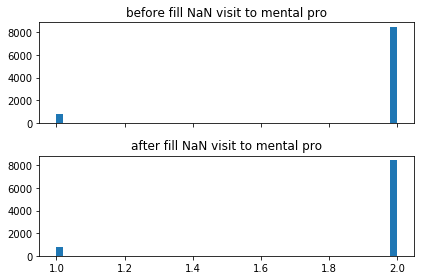

In [812]:
# df6 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac
df6 = pd.merge(df5, dfs_huac, on = 'SEQN', left_index =  True, sort = False)
df6 = process_79(df6,'health conditions',[7,9],'drop')
df6 = fill_NaN(df6,'health conditions','mode') 
df6 = process_79(df6,'health compared to a year ago',[7,9],'drop')
df6 = fill_NaN(df6,'health compared to a year ago','mode') 
df6 = process_79(df6,'visit to mental pro',[7,9],'drop')
df6 = fill_NaN(df6,'visit to mental pro','mode') 

### Housing Characteristics (HC)

#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 31126 entries, 1.0 to 31126.0
Data columns (total 2 columns):
home type         30658 non-null float64
home ownership    30658 non-null float64
dtypes: float64(2)
memory usage: 729.5 KB


NaN    468
2.0     17980
4.0      7175
3.0      2608
1.0      2449
5.0       252
6.0       168
9.0        17
7.0         4
99.0        3
77.0        2
Name: home type, dtype: int64

NaN    468
1.0    17994
2.0    11968
3.0      667
7.0       20
9.0        9
Name: home ownership, dtype: int64


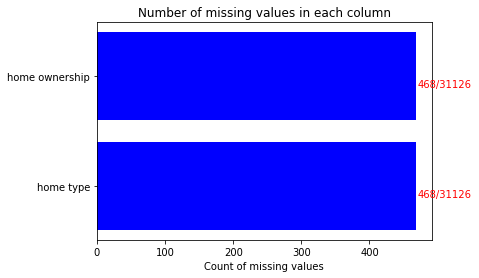

,home type,home ownership
SEQN,,
1.0,2.0,2.0
2.0,4.0,2.0
3.0,4.0,2.0
4.0,2.0,2.0
5.0,2.0,1.0


In [813]:
HOQ = pd.read_sas(datadir+'HOQ.XPT')
HOQ_B = pd.read_sas(datadir+'HOQ_B.XPT')
HOQ_C = pd.read_sas(datadir+'HOQ_C.XPT')
hc_cols_1 = ['SEQN', 'HOD010', 'HOQ065']
hc_cols_2 = ['SEQN', 'HOD011', 'HOQ065']
hc_renamed_cols = ['SEQN','home type','home ownership']
hc_cols_type = ['SEQN','c','c']
hc_file_cols = [(HOQ,hc_cols_1),(HOQ_B,hc_cols_1),(HOQ_C,hc_cols_2)]
dfs_hc = concat_rename_dfs(hc_file_cols,hc_renamed_cols,"dfs_hc.csv")

dfs_hc.info()
get_value_count(dfs_hc,hc_renamed_cols,hc_cols_type)
plot_NaN_abundance_for_all_cols(dfs_hc)
dfs_hc.head()

#### step 2. Fill NaN and convert to dummies
These two variables are all nominal. First fill NaN, then drop 7/9 in both since 7/9 ratio is small. Finally, convert them to dummies.  
- home type	
- home ownership


The NaN ratio in home type is 0.011
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  home type is  9088
after filling NaN, valid entries of  home type is  9192

The NaN ratio in home ownership is 0.012
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  home ownership is  9080
after filling NaN, valid entries of  home ownership is  9192
<class 'pandas.core.frame.DataFrame'>
Float64Index: 9192 entries, 5.0 to 31125.0
Data columns (total 23 columns):
age                              9192 non-null float64
race                             9192 non-null float64
family income                    9192 non-null float64
education                        9192 non-null float64
marital status                   9192 non-null float64
male            

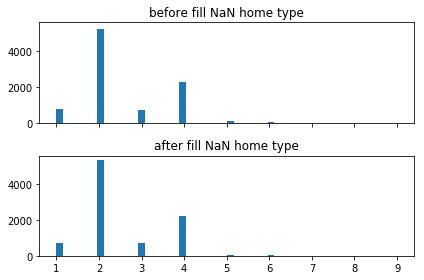

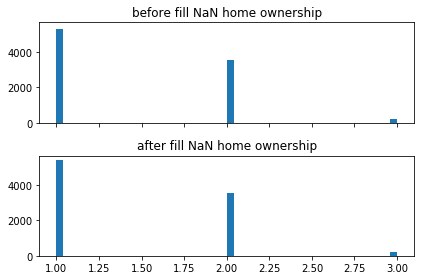

In [814]:
# df7 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc
df7 = pd.merge(df6, dfs_hc, on = 'SEQN', left_index =  True, sort = False)

# Fill NaN
df7 = process_79(df7,'home type',[77,99],'drop')
get_NaN_ratio_for_one_col(df7,'home type')
df7 = fill_NaN(df7, 'home type', 'mode')

df7 = process_79(df7,'home ownership',[7,9],'NaN')
get_NaN_ratio_for_one_col(df7,'home ownership')
df7 = fill_NaN(df7, 'home ownership', 'mode')
df7.info()

## Smoking (SM)
dreamalist major modifications:
1. For SMQ040 -> cur sm status, we find that the numbers of missing values are close to those who are light or non smokers -> sm 100 cig?. Hence, we simply substitute the nan values in 'SMQ040' with 3 (not currently smoking)???? heavy smokers tend to not answer rather than light smokers? 
2. For 'SMD070' = 'sm daily freq',we substitute the missing values as 0 (as those who do not smoke now will not answer this question. making it a multi-class variable with 1 denoting heavy smokers, 2 denoting moderate smokers, and 3 denoting light smokers.????
       missing values not necessarily means non smokers. could due to high freq ?
       multi-class variable: see bear notes

##### SMQ040: Do you now smoke cigarettes --> cur sm status
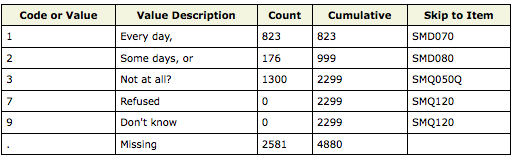


#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 15332 entries, 2.0 to 31125.0
Data columns (total 8 columns):
sm 100 cig?         15324 non-null float64
cur sm status       7391 non-null float64
sm daily freq       2708 non-null float64
sm monthly freq     3302 non-null float64
quit sm num         4089 non-null float64
quit sm unit        4065 non-null float64
sm yrs              2708 non-null float64
nicotine content    2837 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


NaN    8
2.0    7905
1.0    7392
9.0      18
7.0       9
Name: sm 100 cig?, dtype: int64

NaN    7941
3.0    4089
1.0    2708
2.0     593
9.0       1
Name: cur sm status, dtype: int64

count    2708.000000
mean       17.054284
std        34.390976
min         1.000000
25%        10.000000
50%        15.000000
75%        20.000000
max       999.000000
Name: sm daily freq, dtype: float64

count    3302.000000
mean       26.149303
std         8.467580
min         0.000000
25%        30.000000
50%        3

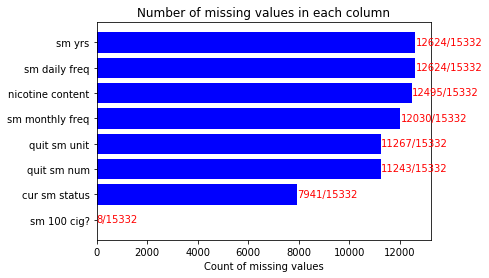

,sm 100 cig?,cur sm status,sm daily freq,sm monthly freq,quit sm num,quit sm unit,sm yrs,nicotine content
SEQN,,,,,,,,
2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,1.0,3.0,NaN,NaN,5.0,3.0,NaN,NaN
7.0,1.0,3.0,NaN,NaN,20.0,4.0,NaN,NaN
10.0,1.0,1.0,10.0,30.0,NaN,NaN,25.0,1.2
12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [815]:
SMQ = pd.read_sas(datadir+'SMQ.XPT')
SMQ_B = pd.read_sas(datadir+'SMQ_B.XPT')
SMQ_C = pd.read_sas(datadir+'SMQ_C.XPT')
sm_cols = ['SEQN', 'SMQ020', 'SMQ040', 'SMD070','SMD080','SMQ050Q','SMQ050U','SMD075', 'SMD100NI']
sm_cols_c = ['SEQN', 'SMQ020', 'SMQ040', 'SMD070','SMD641','SMQ050Q','SMQ050U','SMD075', 'SMD100NI']
sm_renamed_cols = ['SEQN','sm 100 cig?','cur sm status','sm daily freq','sm monthly freq','quit sm num','quit sm unit','sm yrs','nicotine content']
sm_cols_type = ['SEQN','c','c','n','n','n','c','n','n']
sm_file_cols = [(SMQ,sm_cols),(SMQ_B,sm_cols),(SMQ_C,sm_cols_c)]
dfs_sm = concat_rename_dfs(sm_file_cols,sm_renamed_cols,"dfs_sm.csv")

dfs_sm.info()
get_value_count(dfs_sm,sm_renamed_cols,sm_cols_type)
plot_NaN_abundance_for_all_cols(dfs_sm)
dfs_sm.head()

#### step 2. Fill NaN
- sm 100 cig?: Direct fill	

???? 这里咋处理 有点晕


The following variables are all related:
- cur sm status:
    - based on count values:
        - num of (1.0 smoke every day) = 2708 = sm daily freq valid entries
        - num of (2.0 smoke some days) = 593  < sm monthly freq valid entries 
        - num of (3.0 not at all     ) = 4089 = quit sm num valid entries
        
- sm daily freq	
- sm monthly freq: 
    - from histogram of monthly smoking frequency and value counts information above, we can see that the most people choose 2 from cur sm status actually smoke on daily basis.  	
- quit sm num	
- quit sm unit


- sm yrs	
- nicotine content

Let's deal with cur sm status and its related variables first before merging the smoking questions to the previous dataframe


before filling NaN, valid entries of  sm 100 cig? is  15297
after filling NaN, valid entries of  sm 100 cig? is  15332


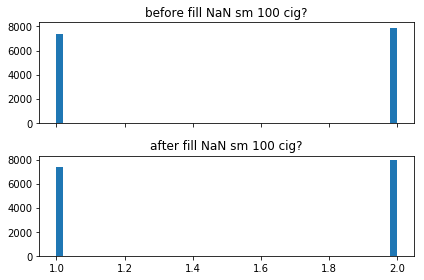

In [816]:
dfs_sm = process_79(dfs_sm,'sm 100 cig?',[7,9],'NaN')
dfs_sm = fill_NaN(dfs_sm, 'sm 100 cig?', 'mode')


The NaN ratio in cur sm status is 0.518
Since NaN ratio is large, predict NaN using ML or check predictability first...
if check predictability, call: check_predictability_all/some_x(dfs,y,method)
if predict using ML, call: predict_NaN_with_ML(dfs,x,y,data_type,model)
This histogram shows the number of days people smoke in a month


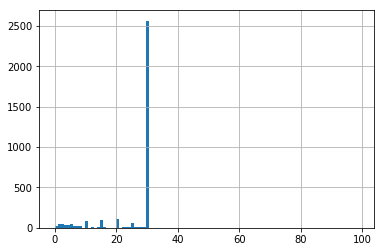

In [817]:
get_NaN_ratio_for_one_col(dfs_sm,'cur sm status')
df_sm_status = dfs_sm[['cur sm status','sm daily freq','sm monthly freq','quit sm num','quit sm unit']]
df_sm_status['sm monthly freq'].hist(bins = 100)
print('This histogram shows the number of days people smoke in a month')

In [818]:
# quit sm num & quit sm unit

df_sm_status['quit sm days'] = 0
for SEQN,unit in df_sm_status['quit sm unit'].iteritems():
    quit_sm_num = df_sm_status.loc[SEQN]['quit sm num']
    if unit == 1:   # day
        quit_sm_days = quit_sm_num
    elif unit == 2: # week
        quit_sm_days = quit_sm_num * (7)
    elif unit == 3: # month
        quit_sm_days = quit_sm_num * (30)
    elif unit == 4: # year
        quit_sm_days = quit_sm_num * (365)
    else:              # NaN: doing nothing for now
        quit_sm_days = None
    df_sm_status.set_value(SEQN,'quit sm days',quit_sm_days)
    
    
df_sm_status = df_sm_status.drop(['quit sm num','quit sm unit'],axis=1)

### to do:
merge df_sm_status back to dfs_sm after dealing with above..skip for now

In [819]:
# df8 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc
df8 = pd.merge(df7, dfs_sm, on = 'SEQN', left_index =  True, sort = False)

Delete the following cell after handling the previous problem related to cur sm status.

In [820]:
features = df8.columns.tolist()
features_to_remove = [
 'cur sm status',
 'sm daily freq',
 'sm monthly freq',
 'quit sm num',
 'quit sm unit']
for f in features_to_remove: features.remove(f)
df8 = df8[features]


The NaN ratio in sm yrs is 0.784
Since NaN ratio is large, predict NaN using ML or check predictability first...
if check predictability, call: check_predictability_all/some_x(dfs,y,method)
if predict using ML, call: predict_NaN_with_ML(dfs,x,y,data_type,model)

Predict the missing values of sm yrs using  random forest  Regressor...
Features are: ['age', 'race', 'family income', 'education', 'marital status', 'male', 'female', 'freq:12 drinks/yr?', 'alco freq year', 'pk use', 'high BP', 'high BC', 'take med', 'diet status', 'weight control status', 'exercise status', 'diabetes status', 'ever use cocaine', 'health conditions', 'health compared to a year ago', 'visit to mental pro', 'home type', 'home ownership', 'sm 100 cig?']
The number of predicted values: 7204

before filling NaN, valid entries of  sm yrs is  1988
after filling NaN, valid entries of  sm yrs is  9192

The NaN ratio in nicotine content is 0.763
Since NaN ratio is large, predict NaN using ML or check predictability fir

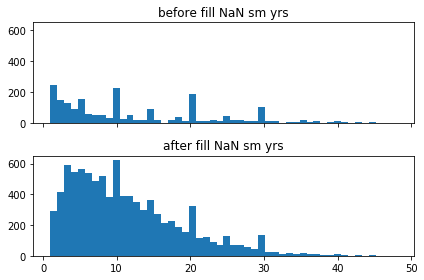

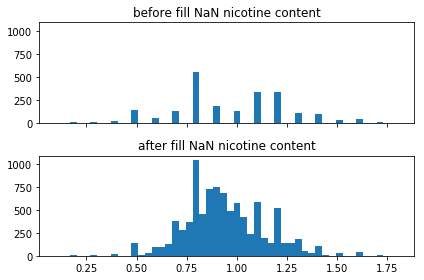

In [821]:
df8 = process_79(df8,'sm yrs',[777,999],'NaN')
get_NaN_ratio_for_one_col(df8, 'sm yrs')
fill_NaN_with_ML_all_x(df8,'sm yrs','numerical','random forest')
get_NaN_ratio_for_one_col(df8, 'nicotine content')
fill_NaN_with_ML_all_x(df8,'nicotine content','numerical','random forest')


## Occupation (OC)

questions:
1. 'weekly work hrs' - 
    1. "Because people without work or has not worked last week tend not to answer this question. We replace the missing and 7/9 values in this variable with 0" 这个变量的取值范围是1 to 160，让missing values都变成1？ 尽量小？
    2. convert to multivariable?



#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 20142 entries, 2.0 to 31125.0
Data columns (total 2 columns):
work type          18884 non-null float64
weekly work hrs    9316 non-null float64
dtypes: float64(2)
memory usage: 472.1 KB


NaN    1258
1.0    9275
4.0    8640
3.0     507
2.0     448
7.0      13
9.0       1
Name: work type, dtype: int64

count     9316.000000
mean       100.886110
std       2451.234956
min          1.000000
25%         30.000000
50%         40.000000
75%         45.000000
max      99999.000000
Name: weekly work hrs, dtype: float64


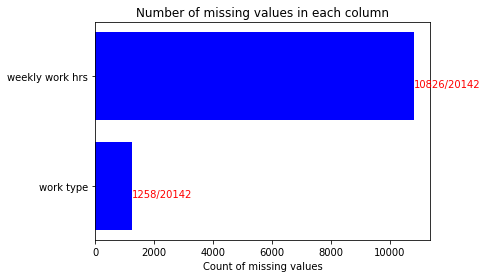

,work type,weekly work hrs
SEQN,,
2.0,2.0,NaN
5.0,1.0,40.0
6.0,4.0,NaN
7.0,1.0,45.0
8.0,NaN,NaN


In [822]:
OCD = pd.read_sas(datadir+'OCQ.XPT')
OCD_B = pd.read_sas(datadir+'OCQ_B.XPT')
OCD_C = pd.read_sas(datadir+'OCQ_C.XPT')
OCD_cols = ['SEQN', 'OCQ150', 'OCQ180']
OCD_B_cols = ['SEQN', 'OCD150', 'OCD180']
OCD_C_cols = ['SEQN', 'OCD150', 'OCQ180']
oc_renamed_cols = ['SEQN','work type','weekly work hrs']
oc_cols_type = ['SEQN','c','n']
oc_file_cols = [(OCD,OCD_cols),(OCD_B,OCD_B_cols),(OCD_C,OCD_C_cols)]
dfs_oc = concat_rename_dfs(oc_file_cols,oc_renamed_cols,"dfs_oc.csv")

dfs_oc.info()
get_value_count(dfs_oc,oc_renamed_cols,oc_cols_type)
plot_NaN_abundance_for_all_cols(dfs_oc)
dfs_oc.head()

#### step 2. Fill NaN
- work type
- weekly work hrs


The NaN ratio in work type is 0.000
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

The NaN ratio in weekly work hrs is 0.306
Since NaN ratio is large, predict NaN using ML or check predictability first...
if check predictability, call: check_predictability_all/some_x(dfs,y,method)
if predict using ML, call: predict_NaN_with_ML(dfs,x,y,data_type,model)

before filling NaN, valid entries of  work type is  9189
after filling NaN, valid entries of  work type is  9192

Predict the missing values of weekly work hrs using  random forest  Regressor...
Features are: ['age', 'race', 'family income', 'education', 'marital status', 'male', 'female', 'freq:12 drinks/yr?', 'alco freq year', 'pk use', 'high BP', 'high BC', 'take med', 'diet status', 'weight control status', 'exercise status', 'diabetes status', 'ever use cocaine', 'health conditions', 'health compared to a year ago', 'visit to mental pro', '

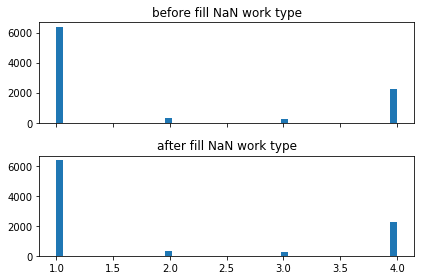

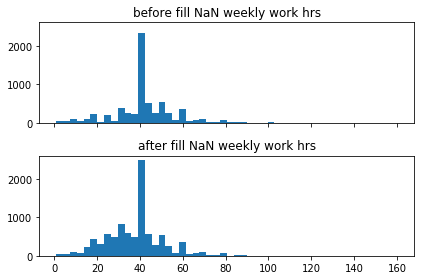

In [823]:
# df9 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc + dfs_oc
df9 = pd.merge(df8, dfs_oc, on = 'SEQN', left_index =  True, sort = False)
df9 = process_79(df9,'work type',[7,9],'NaN')
get_NaN_ratio_for_one_col(df9,'work type')
df9 = process_79(df9,'weekly work hrs',[77777,99999],'NaN')
get_NaN_ratio_for_one_col(df9,'weekly work hrs')
fill_NaN(df9, 'work type', 'mode')
fill_NaN_with_ML_all_x(df9,'weekly work hrs','numerical','random forest')

### Physical Activity - Individual Activities (PA)

#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 13871 entries, 5.0 to 31123.0
Data columns (total 3 columns):
activity level           13871 non-null float64
monthly activity freq    13857 non-null float64
activity duration        13858 non-null float64
dtypes: float64(3)
memory usage: 433.5 KB


NaN    0
1.0    10681
2.0     3190
Name: activity level, dtype: int64

count    13857.000000
mean        13.340117
std         17.484697
min          1.000000
25%          4.000000
50%          9.000000
75%         17.000000
max        300.000000
Name: monthly activity freq, dtype: float64

count    13858.000000
mean        62.251046
std         66.071766
min         10.000000
25%         20.000000
50%         30.000000
75%         60.000000
max        600.000000
Name: activity duration, dtype: float64


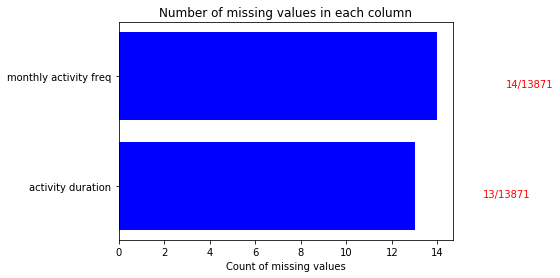

,activity level,monthly activity freq,activity duration
SEQN,,,
5.0,1.0,4.0,30.0
6.0,1.0,21.0,20.0
7.0,1.0,13.0,15.0
8.0,2.0,1.0,29.0
11.0,1.0,9.0,20.0


In [824]:
PAQIAF = pd.read_sas(datadir+'PAQIAF.XPT')
PAQIAF_B = pd.read_sas(datadir+'PAQIAF_B.XPT')
PAQIAF_C = pd.read_sas(datadir+'PAQIAF_C.XPT')
PAQIAF_cols = ['SEQN','PADLEVEL','PADTIMES','PADDURAT']
pa_renamed_cols = ['SEQN','activity level','monthly activity freq','activity duration']
pa_cols_type = ['SEQN','c','n','n']
pa_file_cols = [(PAQIAF,PAQIAF_cols),(PAQIAF_B,PAQIAF_cols),(PAQIAF_C,PAQIAF_cols)]
dfs_pa = concat_rename_dfs(pa_file_cols,pa_renamed_cols,"dfs_pa.csv")

dfs_pa.info()
get_value_count(dfs_pa,pa_renamed_cols,pa_cols_type)
plot_NaN_abundance_for_all_cols(dfs_pa)
dfs_pa.head()

#### step 2. Fill NaN
Direct fill for all since NaN ratios are small


before filling NaN, valid entries of  monthly activity freq is  13857
after filling NaN, valid entries of  monthly activity freq is  13871

before filling NaN, valid entries of  activity duration is  13858
after filling NaN, valid entries of  activity duration is  13871


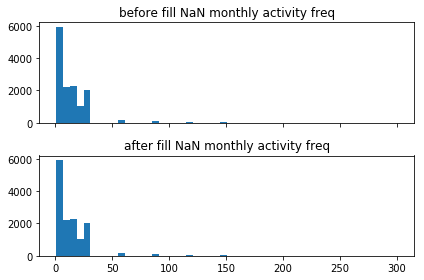

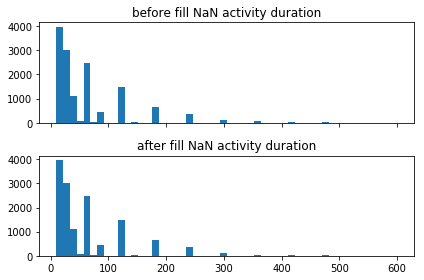

In [825]:
dfs_pa_1 = fill_NaN(dfs_pa, 'monthly activity freq', 'mean')
dfs_pa_2 = fill_NaN(dfs_pa_1, 'activity duration', 'mean')
dfs_pa = dfs_pa_2

# df10 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc + dfs_oc + dfs_pa
df10 = pd.merge(df9, dfs_pa, on = 'SEQN', left_index =  True, sort = False)

### Weight history (WH)

#### step 1. load data and describe data

<class 'pandas.core.frame.DataFrame'>
Float64Index: 18891 entries, 2.0 to 31125.0
Data columns (total 4 columns):
cur height(in)           18809 non-null float64
cur weight(lb)           18835 non-null float64
weight goal              18882 non-null float64
past weight(-1yr)(lb)    18848 non-null float64
dtypes: float64(4)
memory usage: 737.9 KB


count    18809.000000
mean       275.293423
std       1423.488025
min         39.000000
25%         63.000000
50%         66.000000
75%         70.000000
max       9999.000000
Name: cur height(in), dtype: float64

count    18835.000000
mean       966.489886
std       8435.718063
min         50.000000
25%        140.000000
50%        165.000000
75%        194.000000
max      99999.000000
Name: cur weight(lb), dtype: float64

NaN    9
2.0    10162
3.0     6945
1.0     1724
9.0       39
7.0       12
Name: weight goal, dtype: int64

count    18848.000000
mean      1279.244960
std      10011.247158
min         55.000000
25%        135.000000
50%  

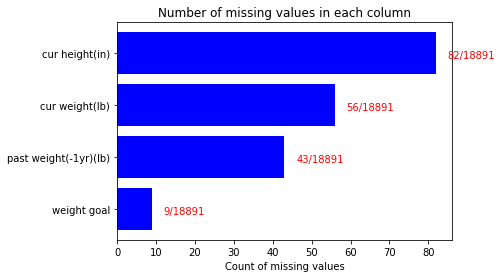

,cur height(in),cur weight(lb),weight goal,past weight(-1yr)(lb)
SEQN,,,,
2.0,69.0,168.0,3.0,168.0
5.0,71.0,206.0,2.0,192.0
6.0,64.0,132.0,2.0,115.0
7.0,65.0,176.0,2.0,173.0
10.0,75.0,200.0,3.0,99999.0


In [826]:
WHQ = pd.read_sas(datadir+'WHQ.XPT')
WHQ_B = pd.read_sas(datadir+'WHQ_B.XPT')
WHQ_C = pd.read_sas(datadir+'WHQ_C.XPT')
WHQ_cols = ['SEQN', 'WHD010', 'WHD020','WHD040', 'WHD050']
WHQ_B_cols = ['SEQN', 'WHD010', 'WHD020','WHQ040', 'WHD050']
WHQ_C_cols = ['SEQN', 'WHD010', 'WHD020','WHQ040', 'WHD050']
wh_renamed_cols = ['SEQN','cur height(in)','cur weight(lb)','weight goal','past weight(-1yr)(lb)']
wh_cols_type = ['SEQN','n','n','c','n']
wh_file_cols = [(WHQ,WHQ_cols),(WHQ_B,WHQ_B_cols),(WHQ_C,WHQ_C_cols)]
dfs_wh = concat_rename_dfs(wh_file_cols,wh_renamed_cols,"dfs_wh.csv")

dfs_wh.info()
get_value_count(dfs_wh,wh_renamed_cols,wh_cols_type)
plot_NaN_abundance_for_all_cols(dfs_wh)
dfs_wh.head()

#### step 2. Fill NaN
Direct fill for all since NaN ratios are small


before filling NaN, valid entries of  cur height(in) is  18412
after filling NaN, valid entries of  cur height(in) is  18891

before filling NaN, valid entries of  cur weight(lb) is  18698
after filling NaN, valid entries of  cur weight(lb) is  18891

before filling NaN, valid entries of  weight goal is  18831
after filling NaN, valid entries of  weight goal is  18891

before filling NaN, valid entries of  past weight(-1yr)(lb) is  18656
after filling NaN, valid entries of  past weight(-1yr)(lb) is  18891


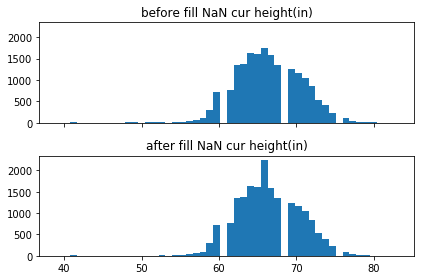

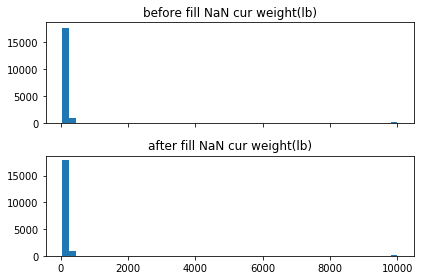

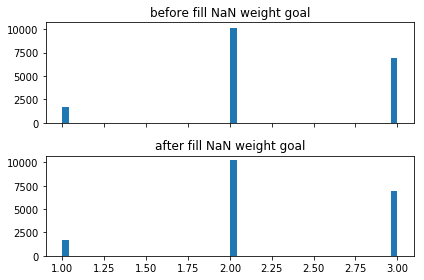

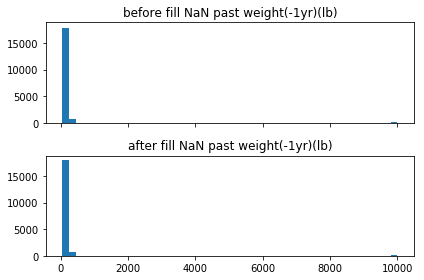

In [827]:
dfs_wh = process_79(dfs_wh,'cur height(in)',[7777,9999],'NaN')
dfs_wh = process_79(dfs_wh,'cur weight(lb)',[77777,99999],'NaN')
dfs_wh = process_79(dfs_wh,'weight goal',[7,9],'NaN')
dfs_wh = process_79(dfs_wh,'past weight(-1yr)(lb)',[77777,99999],'NaN')

dfs_wh_1 = fill_NaN(dfs_wh, 'cur height(in)', 'mode')
dfs_wh_2 = fill_NaN(dfs_wh_1, 'cur weight(lb)', 'mode')
dfs_wh_3 = fill_NaN(dfs_wh_2, 'weight goal', 'mode')
dfs_wh_4 = fill_NaN(dfs_wh_3, 'past weight(-1yr)(lb)', 'mode')
dfs_wh = dfs_wh_4

1. Group 'cur height(in)' and 'cur weight(lb)' into BMI
        BMI = weight(lb)/(height(in)^2)*703
2. Group 'cur weight(lb)' and 'past weight(-1yr)(lb)' into weight change: change of weight from last year to this year
        weight change = (cur weight)/(past weight)
        weight change > 1: weight gain
        weight change < 1: weight loss
        * use ratio instead of (cur weight) - (past weight) to avoid negative values
3. Categorize 'weight change' from step 2 into a 3 values variables: see table in step 4

4. Group weight change obtained from previous step and weight goal into weight_goal_outcome: what's the goalion of the weight and what's the actual resulting weight change? 

| weight goal               | weight change                 |
|---------------------------|-------------------------------|
| 1 - want to gain          | 1 - gain: > 1.1               |
| 2 - want to lose          | 2 - loss: < 0.9               |
| 3 - want to stay the same | 3 - about the same: 0.9 ~ 1.1 |

* For this new variable 'weight_goal_outcome': 
    * 1 means Yes - successfully achieve weight goal & goal matches with actual result; goal = change
    * 2 means NO - fails to achieve weight goal 

| (weight goal, weight change) code   | weight_goal_change code |
|-------------------------------------|---------------------------|
| 1,1                                 | 1                         |
| 1,2                                 | 2                         |
| 1,3                                 | 2                         |
| 2,1                                 | 1                         |
| 2,2                                 | 2                         |
| 2,3                                 | 2                         |
| 3,1                                 | 2                         |
| 3,2                                 | 2                         |
| 3,3                                 | 1                         |

In [828]:
# step 1. Group 'cur height(in)' and 'cur weight(lb)' into BMI
dfs_wh['BMI'] = dfs_wh['cur weight(lb)']/((dfs_wh['cur height(in)'])**2) * 703

# step 2. Create weight change variable from cur weight & past weight
dfs_wh['weight change'] = dfs_wh['cur weight(lb)']/dfs_wh['past weight(-1yr)(lb)']

# step 3. Categorize 'weight change category'('wcc') from step 2 into a 3 values variables
dfs_wh['weight change(category)'] = 0
dfs_wh['weight change(category)'][dfs_wh['weight change'] > 1.1] = 1 # weight gain
dfs_wh['weight change(category)'][dfs_wh['weight change'] < 0.9] = 2 # weight loss
dfs_wh['weight change(category)'][(dfs_wh['weight change'] >= 0.9) & (dfs_wh['weight change'] <= 1.1)] = 3 # weight stays the same


# step 4. Create weight_goal_outcome based on weight change(category) and weight goal
dfs_wh['weight goal outcome'] = 2 # initialize the col with 2 
dfs_wh['weight goal outcome'][dfs_wh['weight change(category)'] == dfs_wh['weight goal'] ] = 1 # change to 1 if find matches

dfs_wh = dfs_wh.drop(['cur height(in)','cur weight(lb)','past weight(-1yr)(lb)','weight change','weight change(category)','weight goal'], axis=1)
dfs_wh.head()

,BMI,weight goal outcome
SEQN,,
2.0,24.806553,1
5.0,28.728030,2
6.0,22.655273,2
7.0,29.284734,2
10.0,24.995556,2


In [829]:
# df11 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc + dfs_oc + dfs_pa + dfs_wh
df11 = pd.merge(df10, dfs_wh, on = 'SEQN', left_index =  True, sort = False)
df11.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5496 entries, 5.0 to 31116.0
Data columns (total 33 columns):
age                              5496 non-null float64
race                             5496 non-null float64
family income                    5496 non-null float64
education                        5496 non-null float64
marital status                   5496 non-null float64
male                             5496 non-null uint8
female                           5496 non-null uint8
freq:12 drinks/yr?               5496 non-null float64
alco freq year                   5496 non-null float64
pk use                           5496 non-null float64
high BP                          5496 non-null float64
high BC                          5496 non-null float64
take med                         5496 non-null float64
diet status                      5496 non-null int64
weight control status            5496 non-null int64
exercise status                  5496 non-null int64
diabetes status 

# Load data and process data - Y
For all three types of mental problems, 
- 1: Positive Diagnosis - has mental problems
- 5: Negative Diagnosis - does not have mental problems

### Mental Health - Panic Disorder (PD)

In [830]:
CIQPANIC = pd.read_sas(datadir+'CIQPANIC.XPT')
CIQPANIC_B = pd.read_sas(datadir+'CIQPAN_B.XPT')
CIQPANIC_C = pd.read_sas(datadir+'CIQPAN_C.XPT')
CIQPANIC_cols = ['SEQN', 'CIDPSCOR']
pd_renamed_cols = ['SEQN', 'Panic Disorder Diagnosis']
pd_file_cols = [(CIQPANIC,CIQPANIC_cols),(CIQPANIC_B,CIQPANIC_cols),(CIQPANIC_C,CIQPANIC_cols)]
dfs_pd = concat_rename_dfs(pd_file_cols,pd_renamed_cols,"dfs_pd.csv")

### Mental Health - Generalized Anxiety Disorder (AD)

In [831]:
CIQGAD = pd.read_sas(datadir+'CIQGAD.XPT')
CIQGAD_B = pd.read_sas(datadir+'CIQGAD_B.XPT')
CIQGAD_C = pd.read_sas(datadir+'CIQGAD_C.XPT')
CIQGAD_cols = ['SEQN', 'CIDGSCOR']
ad_renamed_cols = ['SEQN', 'Anxiety Disorder Diagnosis']
ad_file_cols = [(CIQGAD,CIQGAD_cols),(CIQGAD_B,CIQGAD_cols),(CIQGAD_B,CIQGAD_cols)]
dfs_ad = concat_rename_dfs(ad_file_cols,ad_renamed_cols,"dfs_ad.csv")

### Mental Health - Depression (DPS)

In [832]:
CIQDEP = pd.read_sas(datadir+'CIQMDEP.XPT')
CIQDEP_B = pd.read_sas(datadir+'CIQDEP_B.XPT')
CIQDEP_C = pd.read_sas(datadir+'CIQDEP_C.XPT')
CIQDEP_cols = ['SEQN', 'CIDDSCOR']
dps_renamed_cols = ['SEQN','Depression Diagnosis']
dps_file_cols = [(CIQDEP,CIQDEP_cols),(CIQDEP_B,CIQDEP_cols),(CIQDEP_C,CIQDEP_cols)]
dfs_dps = concat_rename_dfs(dps_file_cols,dps_renamed_cols,"dfs_dps.csv")

1. Merge all mental health files into dfy
2. Dropped NaN entries
3. Replace all 5 (negative diagnosis) with 2 to be consistent with categorical x's before
    - 1: True (positive)
    - 2: False (negative)

In [833]:
dfy1 = pd.merge(dfs_pd, dfs_ad, on = 'SEQN', left_index = True, sort = False)
dfy2 = pd.merge(dfy1, dfs_dps, on = 'SEQN', left_index = True, sort = False)
dfy = dfy2.dropna()
print('Before dropping NaN, the number of entries is: ',dfy2.shape[0])
print('After dropping NaN, the number of entries is: ',dfy.shape[0])
dfy = dfy.replace(5, 2)
dfy.stack().value_counts()
dfy.head()

Before dropping NaN, the number of entries is:  1706
After dropping NaN, the number of entries is:  1525


,Panic Disorder Diagnosis,Anxiety Disorder Diagnosis,Depression Diagnosis
SEQN,,,
12.0,2.0,2.0,2.0
20.0,2.0,2.0,2.0
34.0,1.0,2.0,2.0
66.0,2.0,2.0,2.0
69.0,2.0,2.0,2.0


Here, we create a final column in the mental health dataframe indicating general mental status named mental diagnosis. 
    - 1: True (positive) - has one or more mental disorders
    - 2: False (negative) - does not have any mental problems

In [834]:
dfy['mental diagnosis'] = 2
dfy['mental diagnosis'][dfy['Panic Disorder Diagnosis']==1]=1
dfy['mental diagnosis'][dfy['Anxiety Disorder Diagnosis']==1]=1
dfy['mental diagnosis'][dfy['Depression Diagnosis']==1]=1
dfy = dfy.drop(['Panic Disorder Diagnosis','Anxiety Disorder Diagnosis','Depression Diagnosis'],axis=1)
dfy.head()

,mental diagnosis
SEQN,
12.0,2
20.0,2
34.0,1
66.0,2
69.0,2


# Merge X and Y, export as CSV file

In [835]:
dfx = df11
df = pd.merge(dfy, dfx, on = 'SEQN', left_index = True, sort = False)
df.to_csv('Feature engineernig part 1 dataframe.csv',index=False,sep=',')